In [1]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
import joblib
import numpy as np


In [2]:
# dataset_dir = 'sentiment140'
dataset_dir = 'imdb'
# dataset_dir = 'coronaNLP'

max_f = 50
# max_f = 30
# max_f = 20
max_f_str = str(max_f) + 'k'

# n_gram = (1, 1)
# n_gram = (1, 2)
n_gram = (2, 2)

# importing the processed dataframe
df = joblib.load(f'./dataframes/df_{dataset_dir}.pkl')

df = df.drop_duplicates()

df.head()



,review,sentiment
0,one review mention watch 1 oz episod youll hoo...,1
1,wonder littl product br br film techniqu veri ...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1


In [3]:

X = df.iloc[:, 0]


y = df.iloc[:, 1]

X, y

(0        one review mention watch 1 oz episod youll hoo...
 1        wonder littl product br br film techniqu veri ...
 2        thought wonder way spend time hot summer weeke...
 3        basic famili littl boy jake think zombi closet...
 4        petter mattei love time money visual stun film...
                                ...                        
 49995    thought movi right good job wasnt creativ orig...
 49996    bad plot bad dialogu bad act idiot direct anno...
 49997    cathol taught parochi elementari school nun ta...
 49998    im go disagre previous comment side maltin one...
 49999    one expect star trek movi high art fan expect ...
 Name: review, Length: 50000, dtype: object,
 0        1
 1        1
 2        1
 3        0
 4        1
         ..
 49995    1
 49996    0
 49997    0
 49998    0
 49999    0
 Name: sentiment, Length: 50000, dtype: int32)

In [4]:


tfidf = joblib.load(
    f"./vectors/vectorizer_{max_f_str}_{dataset_dir}_{n_gram}.pkl")
tfidf

TfidfVectorizer(max_features=50000, ngram_range=(2, 2),
                tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)

In [5]:

X = tfidf.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((40000, 50000), (40000,))

C:\Users\Enes\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

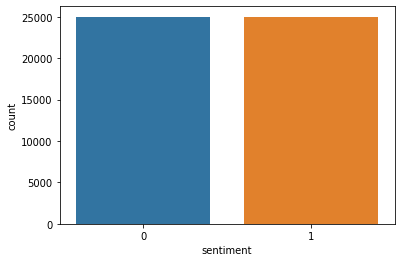

In [6]:
sns.countplot(y)

Text(0.5, 1.0, 'Positive words cloud')

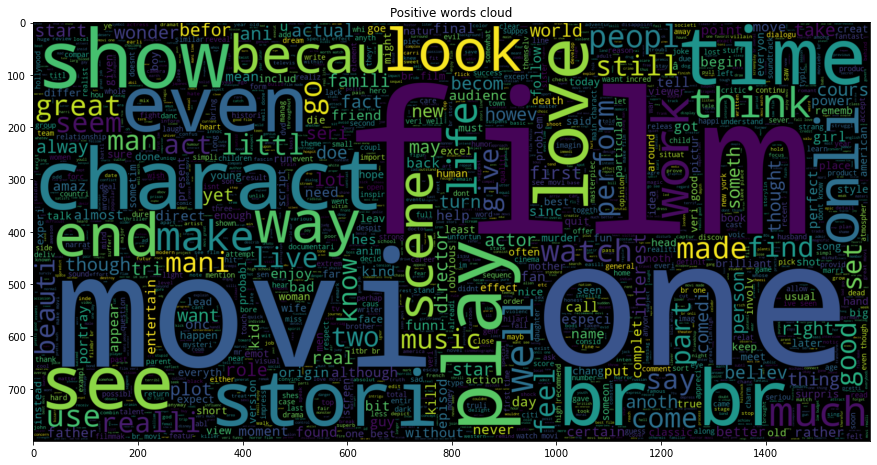

In [7]:
plt.figure(figsize = (15,15)) 
options = [1, 2]
cond = df.iloc[:, 1].isin(options)
result = df[cond].iloc[:, 0].values
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(result))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Positive words cloud')

In [8]:
if dataset_dir == 'coronaNLP':
    plt.figure(figsize=(15, 15))
    options = [0]
    cond = df.iloc[:, 1].isin(options)
    result = df[cond].iloc[:, 0].values
    wc = WordCloud(max_words=2000, width=1600,
                height=800).generate(" ".join(result))
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Neutral words cloud')


Text(0.5, 1.0, 'Negative words cloud')

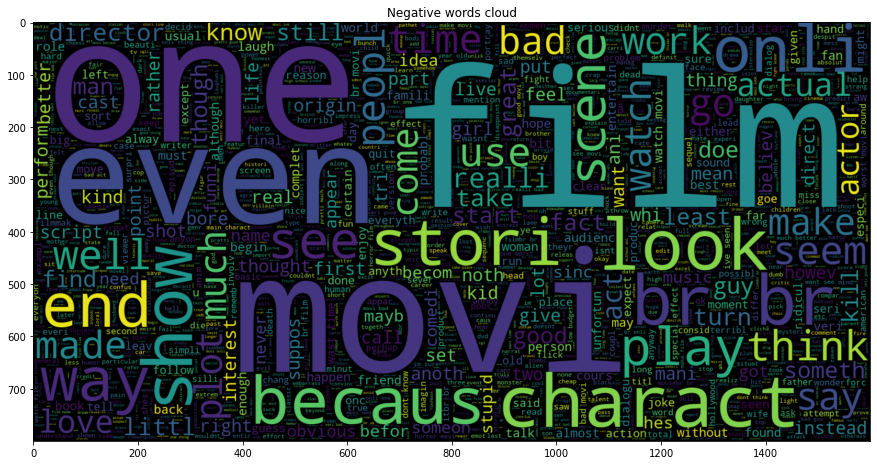

In [10]:
if dataset_dir == 'imdb' or dataset_dir == 'sentiment140':
    options = [0]
else:
    options = [-1, -2]
    
plt.figure(figsize=(15, 15))
cond = df.iloc[:, 1].isin(options)
result = df[cond].iloc[:, 0].values
wc = WordCloud(max_words=2000, width=1600,
               height=800).generate(" ".join(result))
plt.imshow(wc, interpolation='bilinear')
plt.title('Negative words cloud')


In [11]:

# creating our pipeline that will return an estimator
pipeline = Pipeline([('clf', MultinomialNB())])


In [12]:

parameters = {
    'clf__fit_prior': (False, True),
    'clf__alpha': (1, 0.1, 0.01, 0.001)
    }

clf = GridSearchCV(pipeline, param_grid=parameters, scoring='accuracy', cv=5, verbose=1)
clf

GridSearchCV(cv=5, estimator=Pipeline(steps=[('clf', MultinomialNB())]),
             param_grid={'clf__alpha': (1, 0.1, 0.01, 0.001),
                         'clf__fit_prior': (False, True)},
             scoring='accuracy', verbose=1)

In [13]:

clf = clf.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [14]:

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4961
           1       0.88      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [15]:

print("Best: %f using %s" % (clf.best_score_, 
    clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.878825 using {'clf__alpha': 1, 'clf__fit_prior': False}
0.878825 (0.000761) with: {'clf__alpha': 1, 'clf__fit_prior': False}
0.878750 (0.000997) with: {'clf__alpha': 1, 'clf__fit_prior': True}
0.875950 (0.001783) with: {'clf__alpha': 0.1, 'clf__fit_prior': False}
0.875825 (0.001910) with: {'clf__alpha': 0.1, 'clf__fit_prior': True}
0.872225 (0.000663) with: {'clf__alpha': 0.01, 'clf__fit_prior': False}
0.872225 (0.000812) with: {'clf__alpha': 0.01, 'clf__fit_prior': True}
0.868875 (0.002197) with: {'clf__alpha': 0.001, 'clf__fit_prior': False}
0.869025 (0.002187) with: {'clf__alpha': 0.001, 'clf__fit_prior': True}


In [16]:

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

acc = int(accuracy_score(y_test, y_pred)*100)


[[4341  620]
 [ 554 4485]]


In [19]:

# exporting the pipeline
joblib.dump(clf.best_estimator_, f'./models/mnb_{dataset_dir}_{acc}.pkl')

['./models/mnb_imdb_88.pkl']